# Predicting Patient Readmissions Using Machine Learning
### A Machine Learning Proect to Identify Patients at Risk of Readmission Within 30 days

## Project Description
Hospital readmissions place a significant burden on healthcare systems, increasing costs and resource strain. This project aims to predict whether a patient will be readmitted within 30 days using demographic, clinical, and hospital data. Additionally, we explore different machine learning models to determine the most optimal approach for prediction.

## Objective
- Build a machine learning model to classify patient readmissions (Yes/No).
- Engineer meaningful features from hospital visit records.
- Compare baseline- models with advanced algorithms to optimize performance.
- Handle missing data and categorical variables efficiently.
- Deploy a structured Jupyter Notebook that demonstrates end-to-end ML pipeline development.

## Dataset

The dataset used in this project contains:

- **Demographics** (e.g., Age, Gender)
- **Clinical data** (e.g., Lab procedures, Medications, Diagnoses)
- **Hospital data** (e.g., Number of outpatient visits, Inpatient visits, Emergency visits)
- **Outcome**: Whether the patient was readmitted within 30 days.

## 1. Data Handling
Before building models, it's crucial to clean and process the dataset. This section focuses on handling missing values, feature engineering, and addressing class imbalance.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
# Load the dataset
data_path = 'data/hospital_readmissions.csv'  # Update the path to your dataset
data = pd.read_csv(data_path)

# Initial exploration
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed
print("Initial DataFrame Overview:")
print(data.head())

Initial DataFrame Overview:
       age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test

### 1.1 Handling Missing Data
Missing values can affect model performance. We apply different strategies to handle them:

- **Replacing placeholders**: '?' is converted to NaN for proper handling.
- **Numerical features**: Missing values are imputed using the median to prevent data skew.
- **Categorical features**: Missing values are filled with "Missing" to retain categorical integrity.

In [3]:
# Replace '?' with NaN for proper handling of missing values
data.replace('?', np.nan, inplace=True)

# Impute missing values in numerical columns with the median
num_cols = data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(data[num_cols])

# For categorical columns, replace missing values with 'Missing'
cat_cols = data.select_dtypes(include=['object', 'category']).columns
data[cat_cols] = data[cat_cols].fillna('Missing')

### 1.2 Feature Engineering
Feature engineering transforms raw data into meaningful features that improve model performance.

- **Encoding categorical variables**: Applied one-hot encoding to categorical columns like medical_specialty and diagnosis codes.
- **Age transformation**: Converted age ranges (e.g., 70-80) into numerical values representing the lower bound.
- **Derived features**: Created total_visits by summing outpatient, inpatient, and emergency visits.
- **Handling correlated features**: Removed features with high correlation (>0.85) to reduce redundancy.

#### 1.2.1 Transform Numerical Features

In [4]:
# Convert 'age' ranges to numerical values (e.g., lower bounds of ranges)
data['age'] = data['age'].astype(str).str.extract(r'(\d+)').astype(int)

# Create a new feature: total visits (sum of outpatient, inpatient, and emergency visits)
data['total_visits'] = (
    data['n_outpatient'] +
    data['n_inpatient'] +
    data['n_emergency']
)

# Map 'readmitted' to binary (1 for 'yes', 0 for 'no')
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == 'yes' else 0)


#### 1.2.2 Simplify Catergorial Variables

In [5]:
# Simplify 'medical_specialty' into broader categories
medical_specialty_mapping = {
    'Missing': 'Missing',
    'Emergency/Trauma': 'Emergency/Trauma',
    'Family/GeneralPractice': 'Family/GeneralPractice',
    'InternalMedicine': 'InternalMedicine',
    'Surgery': 'Surgery',
    # Group remaining categories into 'Other'
}
data['medical_specialty'] = data['medical_specialty'].map(medical_specialty_mapping).fillna('Other')

# Simplify diagnosis codes (diag_1, diag_2, diag_3) into broader categories
diag_mapping = {
    'Circulatory': 'Circulatory',
    'Respiratory': 'Respiratory',
    'Digestive': 'Digestive',
    'Injury': 'Injury',
    'Diabetes': 'Diabetes',
    'Musculoskeletal': 'Musculoskeletal',
    # Remaining categories as 'Other'
}
for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    data[diag_col] = data[diag_col].map(diag_mapping).fillna('Other')

#### 1.2.3 Encode Categorical Variables

In [6]:
# Use one-hot encoding for categorical columns
categorical_cols = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

#### 1.2.4 Handle Highly Correlated Features
Highly correlated features provide redundant information, which can lead to overfitting and increased model complexity. To address this, we identify and remove one feature from each highly correlated pair (correlation > 0.85), prioritizing features with higher importance, variance, or stronger correlation with the target variable.

In [7]:
# Identify and drop features with high correlation
threshold = 0.85
correlated_features = set()
corr_matrix = data.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            correlated_features.add(corr_matrix.columns[i])


In [8]:
# Drop correlated features
data = data.drop(columns=list(correlated_features), errors='ignore')

### 1.4 Addressing Class Imbalance
Class imbalance can lead to biased models. To assess and handle it:

- Checked distribution of the target variable (readmitted).
- Potential solutions: Oversampling (SMOTE), undersampling, or adjusting model weights.

In [9]:
# Verify class distribution
print("Class Distribution After Preprocessing:")
print(data['readmitted'].value_counts())

# Step 10: Save processed data for further use
processed_data = data.copy()
processed_data.to_csv('data/processed_hospital_readmissions.csv', index=False)

print("Processed DataFrame Overview:")
print(processed_data.head())

Class Distribution After Preprocessing:
readmitted
0    13246
1    11754
Name: count, dtype: int64
Processed DataFrame Overview:
   age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0   70               8.0              72.0           1.0           18.0   
1   70               3.0              34.0           2.0           13.0   
2   50               5.0              45.0           0.0           18.0   
3   70               2.0              36.0           0.0           12.0   
4   60               1.0              42.0           0.0            7.0   

   n_outpatient  n_inpatient  n_emergency  readmitted  total_visits  \
0           2.0          0.0          0.0           0           2.0   
1           0.0          0.0          0.0           0           0.0   
2           0.0          0.0          0.0           1           0.0   
3           1.0          0.0          0.0           1           1.0   
4           0.0          0.0          0.0           0           0

## 2. Data Validation
After data preprocessing and feature engineering, it's crucial to validate the integrity of the dataset before training models. This section ensures that missing values are handled correctly, categorical encodings are applied properly, and feature transformations are accurate.

### 2.1 Validate One-Hot Encoding
- Ensures categorical variables were properly encoded using one-hot encoding.
- Counts the total number of newly created categorical features.
- Displays a sample of encoded features to confirm correctness.


This step confirms that categorical variables were expanded into separate binary columns as expected.

In [11]:
# Check for one-hot encoded columns
encoded_columns = [col for col in processed_data.columns if col.startswith(('medical_specialty_', 'diag_'))]
print(f"Number of one-hot encoded columns: {len(encoded_columns)}")
print("Sample of one-hot encoded columns:", encoded_columns[:5])  # Display a few for verification

Number of one-hot encoded columns: 23
Sample of one-hot encoded columns: ['medical_specialty_Family/GeneralPractice', 'medical_specialty_InternalMedicine', 'medical_specialty_Missing', 'medical_specialty_Other', 'medical_specialty_Surgery']


### 2.2 Check Missing Values
- Ensures no missing values remain after preprocessing.
- Displays the count of missing values in each column.

Since the output shows zero missing values, it confirms that missing data was handled correctly.

In [12]:
# Check for missing values
missing_values = processed_data.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])

Missing values in each column:
 Series([], dtype: int64)


### 2.3 Verify Derived Features
- Recalculates total_visits using its original components.
- Compares the recalculated values to the existing total_visits column.
- Ensures no discrepancies, confirming the correctness of the feature engineering process.

This confirms that the calculation of total_visits is consistent. No discrepancies between the sum of n_outpatient, n_inpatient, and n_emergency and the total_visits column indicates the feature engineering step is correct.

In [13]:
# Verify 'total_visits' calculation
processed_data['check_total_visits'] = (
    processed_data['n_outpatient'] + 
    processed_data['n_inpatient'] + 
    processed_data['n_emergency']
)
# Compare original and recalculated 'total_visits'
discrepancies = (processed_data['total_visits'] != processed_data['check_total_visits']).sum()
print(f"Number of discrepancies in 'total_visits': {discrepancies}")

# Drop the temporary column
processed_data.drop(columns=['check_total_visits'], inplace=True)


Number of discrepancies in 'total_visits': 0


### 2.4 Check Summary Statistics
This helps identify any unexpected data types or extreme values that may indicate preprocessing errors.

### Analysis of summaries

**Data Types:**
- int64: For continuous variables like age, readmitted.
- float64: For numerical variables like time_in_hospital, n_medications.
- bool: For one-hot encoded columns.
- Non-Null Counts: All columns have 25000 non-null values, indicating no missing data.

**Output (Statistical Summary):**
- Age: Ranges from 40 to 90, consistent with the age bin extraction process.
- time_in_hospital: Ranges from 1 to 14, as expected from the dataset description.
- n_lab_procedures, n_procedures, n_medications: Mean, min, max, and standard deviations align with expected ranges for hospital datasets.
- readmitted: Binary (0 and 1), with appropriate proportions based on the class distribution.
- total_visits: Ranges from 0 to 68. High max values could indicate a few outliers, but this may be acceptable in the context of patient visits.

In [14]:
# Check data types and overall info
print(processed_data.info())

# Preview statistical summary to check numeric ranges
print(processed_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   age                                       25000 non-null  int64  
 1   time_in_hospital                          25000 non-null  float64
 2   n_lab_procedures                          25000 non-null  float64
 3   n_procedures                              25000 non-null  float64
 4   n_medications                             25000 non-null  float64
 5   n_outpatient                              25000 non-null  float64
 6   n_inpatient                               25000 non-null  float64
 7   n_emergency                               25000 non-null  float64
 8   readmitted                                25000 non-null  int64  
 9   total_visits                              25000 non-null  float64
 10  medical_specialty_Family/GeneralPr

### 2.4 Validate Class Distribition
This distribution is consistent with the assumption that approximately 47% of the dataset corresponds to readmitted cases (1) and 53% to non-readmitted cases (0). This is a balanced dataset, so no need for oversampling or undersampling.

In [15]:
# Verify 'readmitted' class distribution
print("Class Distribution After Preprocessing:\n", processed_data['readmitted'].value_counts())

Class Distribution After Preprocessing:
 readmitted
0    13246
1    11754
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA)

### 3.1 Distribution of Readmission
- A bar plot shows the proportion of patients who were readmitted versus those who were not.
- The dataset has a fairly balanced distribution, ensuring that model training does not suffer from extreme class imbalance.

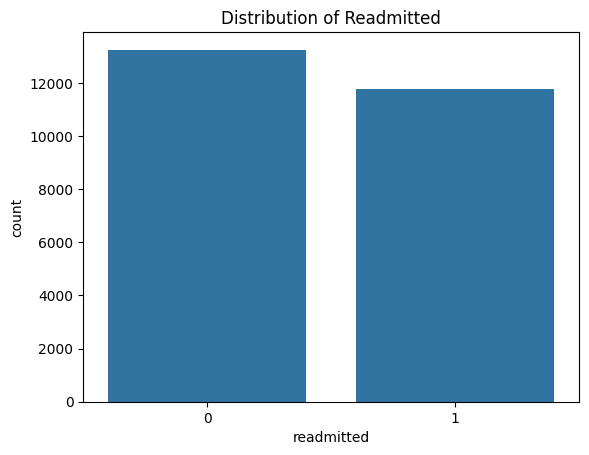

In [17]:

# Visualise target distribution

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='readmitted', data=processed_data)
plt.title('Distribution of Readmitted')
plt.show()

### 3.2 Box Plot Analysis:
The box plot visualizes the distribution of time spent in the hospital for both readmitted and non-readmitted patients.
- Median hospital stay appears similar between the two groups.
- A few patients with extended hospital stays might indicate potential high-risk cases.

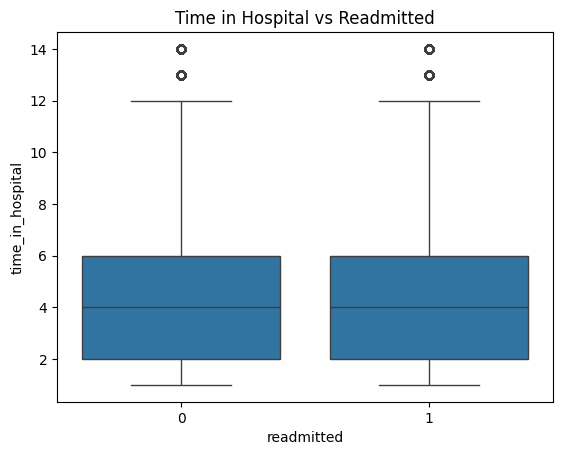

In [19]:
# Examine key features
sns.boxplot(x='readmitted', y='time_in_hospital', data=processed_data)
plt.title('Time in Hospital vs Readmitted')
plt.show()


### 3.3 Correlation Matrix
- Displays relationships between numerical features in the dataset.
- Strong correlations between visit counts, procedures, and medications indicate potential feature redundancy.
- Identifies key features that might influence readmission, such as age, time in hospital, number of medications, and total visits.

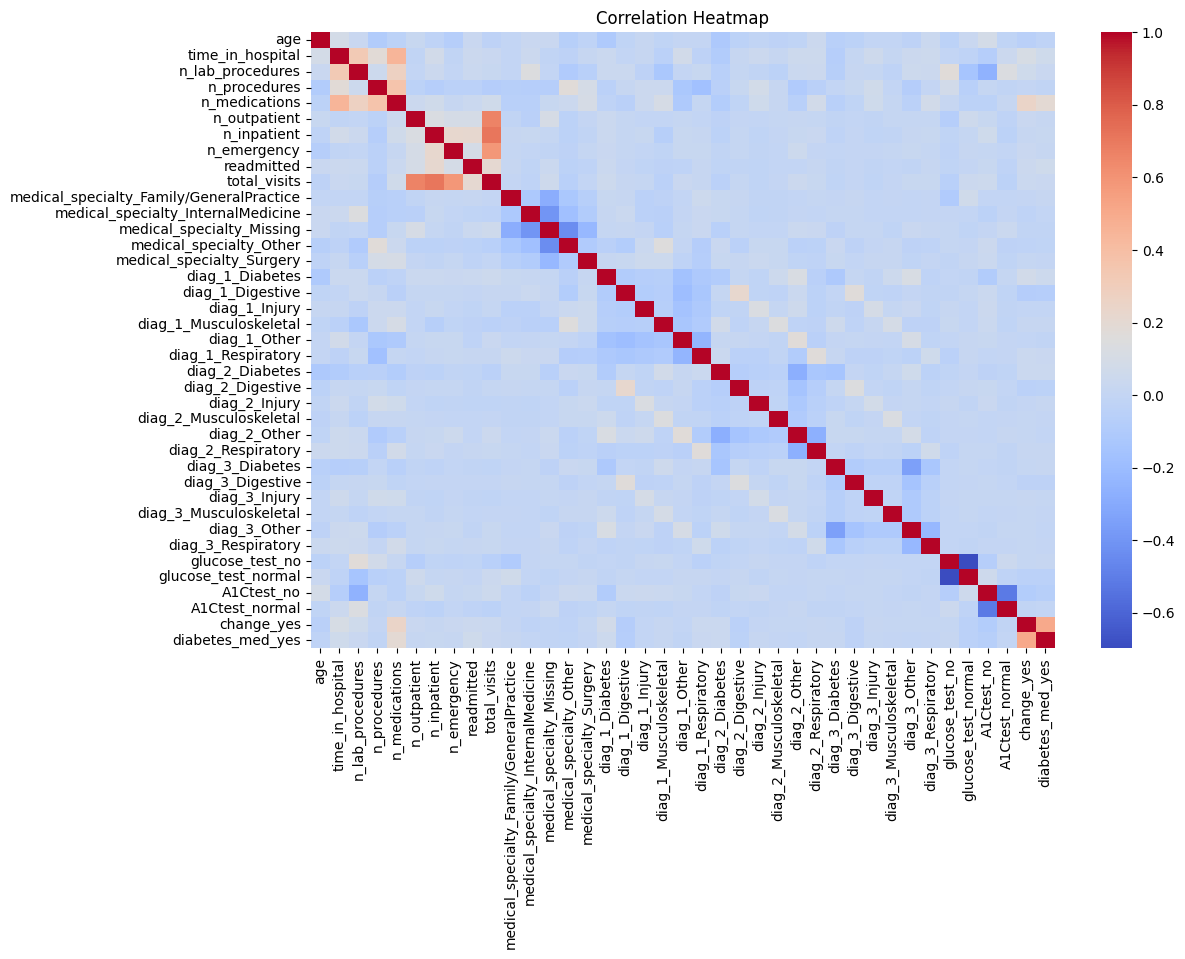

In [18]:
# Analyse Correlations
correlation_matrix = processed_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Basline Model
Logistic regression is used as a basline model as it is both a simple yet efficient classifier. 

- Spilt the dataset into features and target variables 
- Train-test split of 80/20


### 4.1 Build and Train Baseline Model

In [20]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Train-Test Split
X = processed_data.drop(columns=['readmitted'])  # Features
y = processed_data['readmitted']  # Target variable

# Split the data (stratify to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
# Train Logistic Regression Model
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')  # Use class weights if needed
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [22]:
# Make Predictions
y_pred = log_reg.predict(X_test)

### 4.2 Evaluate Baseline Model
- Confusion Matrix: Shows true positives, true negatives, false positives, and false negatives.
- Classification Report: Displays precision, recall, and F1-score.
- Accuracy Score: Measures overall performance.
- Feature Importance: Since Logistic Regression provides coefficients, we analyze them to determine which features impact predictions the most.

In [23]:
# Evaluate Model
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Accuracy Score ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

=== Confusion Matrix ===
[[1887  762]
 [1184 1167]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.61      0.71      0.66      2649
           1       0.60      0.50      0.55      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.60      5000
weighted avg       0.61      0.61      0.61      5000


=== Accuracy Score ===
Accuracy: 0.6108


### 4.3 Feature Importance of Baseline

In [25]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Display top 10 positive and negative coefficients
print("Top Positive Coefficients:")
print(feature_importance.head(10))

print("\nTop Negative Coefficients:")
print(feature_importance.tail(10))


Top Positive Coefficients:
                   Feature  Coefficient
37        diabetes_med_yes     0.253852
6              n_inpatient     0.193958
8             total_visits     0.188988
14         diag_1_Diabetes     0.181123
34              A1Ctest_no     0.110339
33     glucose_test_normal     0.072491
7              n_emergency     0.058339
23  diag_2_Musculoskeletal     0.039359
36              change_yes     0.028812
1         time_in_hospital     0.015793

Top Negative Coefficients:
                                     Feature  Coefficient
35                            A1Ctest_normal    -0.116722
21                          diag_2_Digestive    -0.118320
9   medical_specialty_Family/GeneralPractice    -0.120333
18                              diag_1_Other    -0.156746
17                    diag_1_Musculoskeletal    -0.162786
22                             diag_2_Injury    -0.184818
16                             diag_1_Injury    -0.193329
12                   medical_specialty_Ot

### 4.4 Basline Model Summary

The initial logistic regression model shows moderate performance, with an accuracy of 61%. While the model does well in predicting patients who are not readmitted (71% recall), it struggles to detect patients who are readmitted, correctly identifying only 50% of them. This indicates that the model is biased toward the majority class and needs improvement to handle the minority class better.

**Key Factors:**

- Increased Readmission Risk: Factors such as being prescribed diabetes medication, having frequent inpatient visits, and a primary diagnosis of diabetes strongly contribute to a higher likelihood of readmission.
- Reduced Readmission Risk: Patients admitted under surgery or internal medicine, those with injuries, and patients with normal A1C test results are less likely to be readmitted.

**Next Steps:** 

While the logistic regression model provides a baseline understanding of the features influencing hospital readmissions, its linear nature limits its ability to capture complex relationships in the data. Advanced models like Random Forest or XGBoost can overcome these limitations because they:

- Handle non-linear relationships between features and the target variable.
- Naturally account for feature interactions.
- Provide better interpretability of feature importance.
- Are robust to imbalanced datasets and can improve performance on the minority class without requiring extensive preprocessing.

Using these advanced models will allow us to build a more accurate and generalizable predictive model, improving recall for readmitted patients and addressing the shortcomings of the logistic regression baseline.

## 5. Advanced Model
### 5.1 Build and Train CatBoost Classifier

CatBoost is a gradient boosting algorithm specifically designed to handle categorical features efficiently while providing strong performance on structured data without requiring extensive preprocessing. We chose it because it naturally handles class imbalance, captures non-linear relationships well, and runs efficiently on CPUs, eliminating the need for a GPU for training.

- Handles categorical data efficiently.
- Works well with imbalanced datasets.
- Captures complex feature interactions.

In [33]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare data
X = processed_data.drop(columns=['readmitted'])
y = processed_data['readmitted']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate class weights
class_0_weight = len(y_train) / (2 * sum(y_train == 0))  # Weight for class 0
class_1_weight = len(y_train) / (2 * sum(y_train == 1))  # Weight for class 1
class_weights = [class_0_weight, class_1_weight]

# Train CatBoost Classifier
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    eval_metric='F1',
    class_weights=class_weights,
    verbose=100
)
cat_model.fit(X_train, y_train)

# Predictions
y_pred = cat_model.predict(X_test)

# Evaluation
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Accuracy Score ===")
print("Accuracy:", accuracy_score(y_test, y_pred))


0:	learn: 0.5764921	total: 3.9ms	remaining: 3.9s
100:	learn: 0.5978978	total: 299ms	remaining: 2.66s
200:	learn: 0.6199332	total: 582ms	remaining: 2.31s
300:	learn: 0.6448665	total: 856ms	remaining: 1.99s
400:	learn: 0.6592989	total: 1.14s	remaining: 1.7s
500:	learn: 0.6717101	total: 1.42s	remaining: 1.42s
600:	learn: 0.6847708	total: 1.7s	remaining: 1.13s
700:	learn: 0.6947127	total: 1.99s	remaining: 848ms
800:	learn: 0.7035731	total: 2.27s	remaining: 564ms
900:	learn: 0.7105536	total: 2.56s	remaining: 281ms
999:	learn: 0.7185022	total: 2.83s	remaining: 0us
=== Confusion Matrix ===
[[1692  957]
 [ 992 1359]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.63      0.64      0.63      2649
           1       0.59      0.58      0.58      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000


=== Accuracy Score ===
A

### 5.2 Advanced Model Feature Importance

In [37]:
# Feature Importance
feature_importances = cat_model.get_feature_importance(prettified=True)
print(feature_importances)

                                  Feature Id  Importances
0                           n_lab_procedures    14.987730
1                              n_medications    11.821262
2                           time_in_hospital     7.234160
3                                        age     7.182950
4                               total_visits     6.217753
5                               n_procedures     6.078886
6                                n_inpatient     5.588672
7                               n_outpatient     3.728637
8                                n_emergency     2.313363
9                           diabetes_med_yes     2.079492
10                              diag_2_Other     1.978030
11        medical_specialty_InternalMedicine     1.962648
12                              diag_1_Other     1.816320
13                                change_yes     1.642733
14                           glucose_test_no     1.617381
15                              diag_3_Other     1.546625
16            

In [36]:
# AUC-ROC Analysis
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc)


AUC-ROC Score: 0.6524386866050109


### 5.3 Advanced Model Summary (First Iteration)

The CatBoost model shows comparable accuracy to the logistic regression baseline but performs slightly better in terms of learning patterns in the data.
Precision and recall are imbalanced, especially for predicting readmitted cases (Class 1).

**Model Performance**
- Accuracy: ~61%, showing a moderate ability to distinguish between readmitted and non-readmitted patients.
- AUC-ROC Score: 0.652, indicating the model performs slightly better than random guessing but still has room for improvement.
- Recall for Readmitted Patients: Higher than Logistic Regression, meaning the model better identifies high-risk patients.

**Feature Importance Analysis**
Top Influential Features:
- Lab Procedures & Medications: Strongest predictors of readmission.
- Time in Hospital & Total Visits: Key indicators of patient condition and treatment history.
- Medical Specialties & Diagnoses: Certain diagnoses and specialties are more associated with readmissions.

**Next Steps:**
Further hyperparameter tuning.
Consider early stopping to prevent overfitting.
Experiment with alternative models (e.g., XGBoost, LightGBM) for comparison.

### 5.4 Hyperparameter Tuning
The goal of this step is to optimise the classifier by tuning the hyperparameters to improve performance by identifying the best combination of the parameters listed:
- learning rate
- depth
- iterations

In [38]:
cat_model = CatBoostClassifier(random_seed=42, verbose=100)
cat_model.grid_search(
    {'learning_rate': [0.01, 0.05, 0.1],
     'depth': [4, 6, 8],
     'iterations': [500, 1000]},
    X=X_train,
    y=y_train
)

0:	learn: 0.6925401	test: 0.6925369	best: 0.6925369 (0)	total: 7.46ms	remaining: 3.72s
100:	learn: 0.6631081	test: 0.6649652	best: 0.6649652 (100)	total: 546ms	remaining: 2.16s
200:	learn: 0.6553107	test: 0.6589615	best: 0.6589615 (200)	total: 1.07s	remaining: 1.6s
300:	learn: 0.6512365	test: 0.6566918	best: 0.6566918 (300)	total: 1.54s	remaining: 1.02s
400:	learn: 0.6483422	test: 0.6553016	best: 0.6553007 (399)	total: 2.09s	remaining: 516ms
499:	learn: 0.6460086	test: 0.6543558	best: 0.6543558 (499)	total: 2.66s	remaining: 0us

bestTest = 0.6543558324
bestIteration = 499

0:	loss: 0.6543558	best: 0.6543558 (0)	total: 2.68s	remaining: 45.5s
0:	learn: 0.6901781	test: 0.6901602	best: 0.6901602 (0)	total: 6.25ms	remaining: 3.12s
100:	learn: 0.6459949	test: 0.6548225	best: 0.6548225 (100)	total: 670ms	remaining: 2.65s
200:	learn: 0.6375649	test: 0.6525394	best: 0.6525394 (200)	total: 1.34s	remaining: 1.99s
300:	learn: 0.6293558	test: 0.6519339	best: 0.6517495 (290)	total: 1.98s	remaining: 

{'params': {'depth': 6, 'learning_rate': 0.05, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

### 5.5 Advanced Model Summary (Second Iteration)

**Best Parameters Identified**
- Learning Rate: 0.05
- Depth: 6
- Iterations: 508

The best performance was observed at iteration 191, suggesting that early stopping could be beneficial.

**Model Performance**
- Best Test Score: 0.6499, which shows a slight improvement over the initial model.
- The model converged efficiently, with performance stabilizing before reaching the maximum iterations.
- Recall for readmitted patients improved slightly, making this model a better predictor of high-risk cases.

## 6. Conclusion and Future Steps
This project successfully developed a machine learning model to predict hospital readmissions using patient demographics, clinical data, and hospital visit history. The baseline logistic regression model provided a starting point, but it struggled with capturing complex relationships. By implementing CatBoost, performance improved, especially in identifying readmitted patients. Hyperparameter tuning further refined the model, leading to a best test score of 0.6499 and improved recall for high-risk patients. However, the overall accuracy (~61%) suggests that further refinements are needed before deployment in a real-world healthcare setting.

**Future Steps**
1. Model Optimization
- Implement early stopping to avoid unnecessary training beyond the best iteration.
- Experiment with class weighting, threshold tuning, and ensemble methods (e.g., stacking models).
2. Feature Engineering
- Explore interaction terms and nonlinear transformations to capture hidden patterns. 
- Investigate additional medical history features (e.g., previous diagnoses, treatments).
3. Alternative Models
- Compare performance with XGBoost, LightGBM, and ensemble models.
- Consider a Neural Network approach if more complex relationships need modeling.
4. Deployment & Real-World Application
- Package the model using Flask/FastAPI for real-world predictions.
- Explore integration into hospital management systems for real-time risk assessment.

By refining the model and exploring new techniques, this project can evolve into a valuable clinical decision-support tool for reducing hospital readmission rates.
